In [1]:
import spacy
import pandas as pd
from nltk.tokenize import word_tokenize
import itertools
import re
import numpy as np
import string
from tqdm import tqdm

In [69]:
df = pd.read_excel('training&valid.xlsx')

In [13]:
def ProTweets(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('http\S+', '', text)
    return text

In [ ]:
df['Tweet'] = df['Tweet'].apply(lambda x: ProTweets(x))
df[['Tweet']]

In [71]:
text_ready = ' '.join(df['Tweet'])
text_ready

' Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung dari Januari hinggaxe2x80xa6   Bandar Lampung  Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung daxe2x80xa6   dan jutaan lainnya berada di ambang kelaparan Sebelum kasus pertama COVID19 dilaporkan negara ini pun mengalamixe2x80xa6   InfoKesehatan  AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt   INFOwargaDKI duniaWANITA  Nyamuk membawa penyakit malaria demam berdarah dll jadi bukan nyamuknya sendiri yang membunuh tetapi penyakit yang dibaw TahukahKamu  Tak Selalu Demam Berdarah Penyebab Bintik dan Merah di Badan juga Bisa Jadi Tanda Penyakit Lainnya Apa Saja   InfoKesehatan  AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt   INFOwargaDKI duniaWANITA  Kalau di Indonesia endemik DBD tertinggi antara lain Jabar Jatim Bali DKI tapi malah 10 besar Covid Tapi kalauxe2x80xa6   Mengenal Penyakit Demam Berdarah Dengue Sejak Dini  kontribu

In [2]:
def text_to_tagReadyDF(input):
    text = input
    punctAndSpace = string.punctuation + ' '
    
    dfList = []
    for idx, t in tqdm(enumerate(text)):
        tokens = [[word_tokenize(w), ' '] for w in t.split()]
        tokens = list(itertools.chain(*list(itertools.chain(*tokens))))
        tokens = tokens[:-1]
        
        split_res = []
        for t in tokens:
                line = t.split('-')
                for i,j in enumerate(line):
                    split_res.append(j)
                    if i < len(line)-1:
                        split_res.append('-')
        
        blank = ['' if i.lower() not in list(punctAndSpace) else 'O' for i in split_res]
    
        dfTemp = pd.DataFrame([split_res, blank]).T
        dfTemp.columns = ['token_' + str(idx), 'BIO_tag_'+str(idx)]
        dfList.append(dfTemp)
    
    df = pd.concat(dfList, axis=1)

    return df

In [73]:
tagready_df = text_to_tagReadyDF([text_ready])

1it [00:03,  3.31s/it]


In [74]:
print(tagready_df.shape)
tagready_df

(19521, 2)


,token_0,BIO_tag_0
0,Ditengah,
1,,O
2,pandemi,
3,,O
4,Covid19,
...,...,...
19516,Ini,
19517,,O
19518,FaktornyannLink,
19519,,O


In [13]:
tagready_df.to_excel('data_train.xlsx', index=False)

In [33]:
def convert_to_spacyformat(df, listOfEntities):
    assert not (df.iloc[:,0].isnull().any() or df.iloc[:,1].isnull().any()), 'The dataset contains nan value.'
    
    dictTemp = {}
    dictTemp['token'] = np.array(df.iloc[:,0])
    dictTemp['BIO_tag'] = np.array(df.iloc[:,1].str.lower())
    dictTemp['indices'] = np.array([len(i) for i in dictTemp['token']])
    
    total_idx = [dictTemp['indices'][0]]
    temp = dictTemp['indices'][0]
    
    for i in range(len(dictTemp['indices'])):
        if i > 0:
            temp += dictTemp['indices'][i]
            total_idx.append(temp)
    
    dictTemp['start_idx'] = np.array([total_idx[i-1] if i > 0 else 0 for i in range(len(total_idx))])
    
    dictTemp['end_idx'] = np.array(total_idx)
    del dictTemp['indices']
    
    enti = {}
    entities = []
    text = ''.join(dictTemp['token'])
    
    listOfEntities = ['b-'+i.lower() for i in listOfEntities] + \
                     ['i-'+i.lower() for i in listOfEntities] + \
                     ['e-'+i.lower() for i in listOfEntities] + ['o']
    
    error_tag = []
    error_boolean = []
    for i in np.unique(dictTemp['BIO_tag']):
        if i in listOfEntities:
            error_boolean.append(True)
        else:
            error_boolean.append(False)
            error_tag.append(i)
    assert all(error_boolean), "Some BIO-tag not listed in listOfEntities arg. {}".format(error_tag)
    
   
    for row in range(len(dictTemp['token'])):
        if dictTemp['BIO_tag'][row] != 'o':
            entities.append((dictTemp['start_idx'][row], 
                             dictTemp['end_idx'][row], 
                             dictTemp['BIO_tag'][row]))

    
    start = []
    end = []
    BIO = []
    i = 0
    while i < len(entities):
        try:
            if entities[i][2][2:] == entities[i+1][2][2:]:
                if entities[i][2][0] == 'b':
                    start.append(entities[i][0])
                    i += 1
                    if entities[i][2][0] == 'e':
                        end.append(entities[i][1])
                        BIO.append(entities[i][2][2:])
                        i += 1
                        continue
                    elif entities[i][2][0] == 'i':
                        for j in range(i, len(entities)):
                            if entities[j][2][0] != 'e' and j < len(entities)-1:
                                continue
                            elif entities[j][2][0] == 'e':
                                end.append(entities[j][1])
                                BIO.append(entities[j][2][2:])
                                i = j+1
                                break
                            else:
                                assert 1 == 0, \
                                    "Something error in the BIO-tag you wrote. Error BIO tag: '{}'" \
                                    .format(entities[j][2])
                    elif entities[i][2][0] == 'b':
                        end.append(entities[i-1][1])
                        BIO.append(entities[i-1][2][2:])
                        continue
                        
                  
            else:

                start.append(entities[i][0])
                end.append(entities[i][1])
                BIO.append(entities[i][2][2:])
                i += 1
        except IndexError:
            start.append(entities[i][0])
            end.append(entities[i][1])
            BIO.append(entities[i][2][2:])
            i += 1

    enti['entities'] = [(i,j,k) for i,j,k in zip(start, end, BIO)]
    return [text, enti]

In [24]:
def spacyformat(df):
    l1=[]
    l2=[]
    for i in range(0,len(df['token_0'])):
        l1.append(df['token_0'][i])
        l2.append({'entities':[(0,len(df['token_0'][i]),df['BIO_tag_0'][i])]})
    return list(zip(l1, l2))

In [34]:
annotations = sorted(['orang',
               'lokasi',
               'organisasi',
               ])
annotations

['lokasi', 'orang', 'organisasi']

In [35]:
df_tag = pd.read_excel('data_train_tagged.xlsx')
df_tag.BIO_tag_0.value_counts()

O               18260
b-lokasi          476
e-lokasi          331
i-lokasi          184
b-organisasi      119
b-orang            52
e-organisasi       51
e-orang            21
i-orang            15
i-organisasi       12
Name: BIO_tag_0, dtype: int64

In [36]:
train_data = convert_to_spacyformat(df_tag, annotations)
train_data

['Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung dari Januari hinggaxe2x80xa6 Bandar Lampung Ditengah pandemi Covid19 saat ini Penyakit Demam Berdarah Dengue DBD di Kota Bandar Lampung daxe2x80xa6 dan jutaan lainnya berada di ambang kelaparan Sebelum kasus pertama COVID19 dilaporkan negara ini pun mengalamixe2x80xa6 InfoKesehatan AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt INFOwargaDKI duniaWANITA Nyamuk membawa penyakit malaria demam berdarah dll jadi bukan nyamuknya sendiri yang membunuh tetapi penyakit yang dibaw TahukahKamu Tak Selalu Demam Berdarah Penyebab Bintik dan Merah di Badan juga Bisa Jadi Tanda Penyakit Lainnya Apa Saja InfoKesehatan AWAS DEMAM BERDARAH mengintai kita Cegah dgn cara ini gtgt INFOwargaDKI duniaWANITA Kalau di Indonesia endemik DBD tertinggi antara lain Jabar Jatim Bali DKI tapi malah 10 besar Covid Tapi kalauxe2x80xa6 Mengenal Penyakit Demam Berdarah Dengue Sejak Dini kontributormenulis InfoKeseha

In [28]:
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from spacy.util import decaying
from spacy.training import Example
from spacy.tokens import Doc
import random
from matplotlib import pyplot as plt

In [9]:
def training_spacy(data, iterations):
    
    data_train = data
    nlp=spacy.blank('id')
    
    if 'ner' not in nlp.pipe_names:
        ner = nlp.add_pipe('ner', last=True)
    
    for _, annotations in data_train:
        for ent in annotations.get('entities'):
            ner.add_label(ent[2])
            
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):
        
        nlp.begin_training()
        loss_list = []
        for itn in range(iterations):
            print("Starting iteration " + str(itn))
            random.shuffle(data_train)
            losses = {}
            
            batches = minibatch(data_train, size=compounding(4.0, 64.0, 1.001))
            
            for batch in batches:
                for texts, annotations in batch:
                    doc = nlp.make_doc(texts)
                    example = Example.from_dict(doc, annotations)
                    nlp.update([example], 
                               drop=0.5, 
                               losses=losses,)
            print(losses)
            loss_list.append(losses)
        
    return nlp, loss_list

In [32]:
model, loss = training_spacy([train_data], 100)

Starting iteration 0
{'ner': 9014.642311096191}
Starting iteration 1
{'ner': 8963.517776489258}
Starting iteration 2
{'ner': 8549.268238067627}
Starting iteration 3
{'ner': 8368.91293334961}
Starting iteration 4
{'ner': 7934.497299194336}
Starting iteration 5
{'ner': 7212.829811096191}
Starting iteration 6
{'ner': 6349.871849060059}
Starting iteration 7
{'ner': 5396.789665222168}
Starting iteration 8
{'ner': 4061.363416671753}
Starting iteration 9
{'ner': 3063.386968612671}
Starting iteration 10
{'ner': 1999.652244567871}
Starting iteration 11
{'ner': 1454.1947401762009}
Starting iteration 12
{'ner': 1338.8829434216022}
Starting iteration 13
{'ner': 1273.7556592449546}
Starting iteration 14
{'ner': 1314.4946575164795}
Starting iteration 15
{'ner': 1304.4709095954895}
Starting iteration 16
{'ner': 1271.8478813534603}
Starting iteration 17
{'ner': 1266.443998336792}
Starting iteration 18
{'ner': 1258.5198844000697}
Starting iteration 19
{'ner': 1191.831607170403}
Starting iteration 20
{'

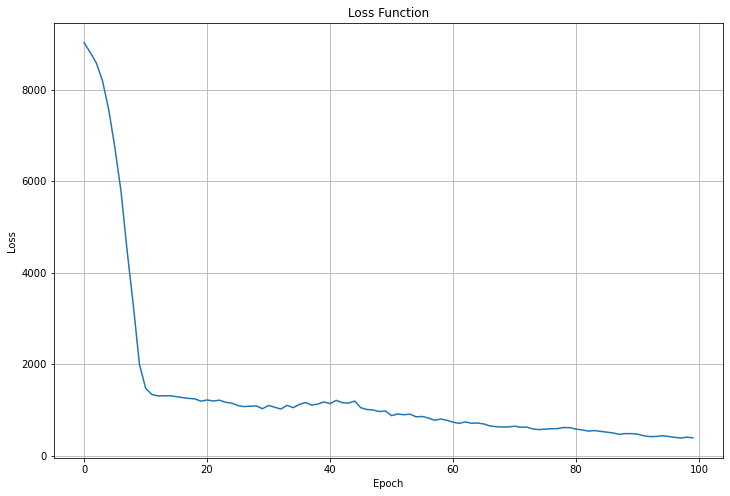

In [186]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.plot([i['ner'] for i in loss])
plt.grid()
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [208]:
modelfile = input("Enter your Model Name: ")
model.to_disk(modelfile)

Enter your Model Name: ModelNerSpacy


In [42]:
from spacy import load, displacy

In [43]:
link_to_model = "ModelNerSpacy"
loaded_model = load(link_to_model)

In [4]:
dt = pd.read_excel('data_test_tagged.xlsx')
dt.BIO_tag_0.value_counts()

O               4309
b-lokasi         155
e-lokasi         122
i-lokasi          50
b-organisasi      32
b-orang           15
e-organisasi      11
e-orang            4
i-orang            2
Name: BIO_tag_0, dtype: int64

In [79]:
def spacyformat(df):
    l1=[]
    l2=[]
    for i in range(0,len(df['token_0'])):
        l1.append(df['token_0'][i])
        l2.append({'entities':[(0,len(df['token_0'][i]),df['BIO_tag_0'][i])]})
    return list(zip(l1, l2))

In [80]:
test_data = spacyformat(dt)
test_data

[('RT', {'entities': [(0, 2, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('Jumlah', {'entities': [(0, 6, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('kasus', {'entities': [(0, 5, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('kematian', {'entities': [(0, 8, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('akibat', {'entities': [(0, 6, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('DBD', {'entities': [(0, 3, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('selama', {'entities': [(0, 6, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('enam', {'entities': [(0, 4, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('bulan', {'entities': [(0, 5, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('terakhir', {'entities': [(0, 8, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('meningkat', {'entities': [(0, 9, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('dua', {'entities': [(0, 3, 'O')]}),
 (' ', {'entities': [(0, 1, 'O')]}),
 ('kali', {'entities': [(0, 4, 'O')]}),
 (' ', {'entities':

In [37]:
from spacy.training import offsets_to_biluo_tags

def get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label
    
def create_target_vector(doc):
    return [get_cleaned_label(label[2]) for label in doc[1]["entities"]]

def create_prediction_vector(text):
    return [get_cleaned_label(prediction) for prediction in get_all_ner_predictions(text)]

def create_total_target_vector(docs):
    target_vector = []
    for doc in docs:
        target_vector.extend(create_target_vector(doc))
    return target_vector

def create_total_prediction_vector(docs: list):
    prediction_vector = []
    for doc in docs:
        prediction_vector.extend(create_prediction_vector(doc[0]))
    return prediction_vector

def get_all_ner_predictions(text):
    doc = loaded_model(text)
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    bilou_entities = offsets_to_biluo_tags(doc, entities)
    return bilou_entities

In [38]:
def get_model_labels():
    labels = list(loaded_model.get_pipe("ner").labels)
    labels.append("O")
    return sorted(labels)

def get_dataset_labels():
    return sorted(set(create_total_target_vector(docs)))

In [39]:
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(docs): 
    classes = sorted(set(create_total_target_vector(docs)))
    y_true = create_total_target_vector(docs)
    y_pred = create_total_prediction_vector(docs)

    return confusion_matrix(y_true, y_pred, classes)

In [44]:
target = create_total_target_vector(test_data)
target

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O'

In [45]:
prediksi = create_total_prediction_vector(test_data)
prediksi

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'lokasi',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',

In [81]:
from matplotlib import pyplot
import numpy

def plot_confusion_matrix(input, normalize=False, cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    title = 'Confusion Matrix, for SpaCy NER'
    docs = input
    classes = sorted(set(create_total_target_vector(docs)))

    # Compute confusion matrix
    cm = generate_confusion_matrix(docs)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    fig, ax = pyplot.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm, ax, pyplot

C:\Users\Apung Nadly\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['O', 'lokasi', 'orang', 'organisasi'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


(array([[4290,   18,    0,    1],
        [ 231,   93,    0,    3],
        [   7,    6,    0,    8],
        [  15,    1,    0,   27]], dtype=int64),
 <module 'matplotlib.pyplot' from 'C:\\Users\\Apung Nadly\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>)

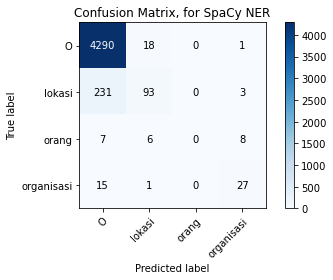

In [82]:
plot_confusion_matrix(test_data, normalize=False)

In [84]:
from sklearn.metrics import classification_report
print(classification_report(target, prediksi))

              precision    recall  f1-score   support

           O       0.94      1.00      0.97      4309
      lokasi       0.79      0.28      0.42       327
       orang       0.00      0.00      0.00        21
  organisasi       0.69      0.63      0.66        43

    accuracy                           0.94      4700
   macro avg       0.61      0.48      0.51      4700
weighted avg       0.93      0.94      0.92      4700

